# ThinkStat2  Chapter2  Exerciseのサンプルコード　実行例


## モジュール類のインポート

In [2]:
#!/usr/bin/python
#-*- encoding: utf-8 -*-
"""
Sample Codes for ThinkStats2 - Chapter3

Copyright 2015 @myuuuuun
URL: https://github.com/myuuuuun/ThinkStats2-Notebook
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""
%matplotlib inline
from __future__ import division, print_function
import sys
sys.path.append('./code')
sys.path.append('../')
import pandas as pd
import nsfg
import relay
import custom_functions as cf
import sys
import math
import numpy as np
import thinkstats2
import thinkplot

## Exercise1

1家庭あたりの子どもの人数の実際の分布と、子どもにアンケートを取って聞いた時の分布の違いを調べる

In [2]:
# 実際の1家族あたりの子供の人数の分布を求める
def Pmf(data):
    pmf = thinkstats2.Pmf(data, label='actual pmf')
    return pmf


# 適当な子どもに対してその家庭の子どもの人数を聞いた時に出てくる、バイアスのかかった子供の人数の分布を求める
def BiasedPmf(data):
    pmf = Pmf(data)
    new_pmf = pmf.Copy(label='biased pmf')

    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    new_pmf.Normalize()
    return new_pmf


# pmfを与えて、平均を返す
def PmfMean(pmf):
    pmf.Normalize()
    average = sum([prob * value for value, prob in pmf.Items()])

    return average

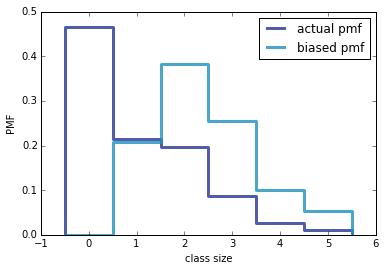

In [3]:
# 分布を比較
df = cf.ReadFemResp()
numkdhh = df.numkdhh
actual_pmf = Pmf(numkdhh)
biased_pmf = BiasedPmf(numkdhh)
thinkplot.PrePlot(2)
thinkplot.Pmfs([actual_pmf, biased_pmf])
thinkplot.Show(xlabel='class size', ylabel='PMF')

In [4]:
# 平均を比較
print("Actual average: ", PmfMean(actual_pmf))
print("Biased average: ", PmfMean(biased_pmf))

Actual average:  1.02420515504
Biased average:  2.40367910066


## Exercise2

pmfを引数にとって平均と分散を返す関数を作る

In [5]:
# pmfを与えて、平均を返す
def PmfMean(pmf):
    pmf.Normalize()
    average = sum([prob * value for value, prob in pmf.Items()])

    return average


# pmfを与えて、分散を返す
def PmfVar(pmf):
    pmf.Normalize()
    average = PmfMean(pmf)
    
    # これは効率が悪い
    #variance = sum([prob * pow(value - average, 2) for value, prob in pmf.Items()])

    # こっちの方がいい
    # Var(x) = E[x^2] - (E[x])^2 を利用
    
    variance = sum([prob * pow(value, 2)]) - pow(average, 2)
    return variance

thinkstats2モジュールに入っているメソッド値が一致しているか調べる

In [6]:
df = cf.ReadFemResp()
numkdhh = df.numkdhh
pmf = Pmf(numkdhh)
print("Average(by my func): ", PmfMean(pmf))
print("Average(by method): ", pmf.Mean())
print("Variance(by my func): ", PmfVar(pmf))
print("Variance(by method): ", pmf.Var())

Average(by my func):  1.02420515504
Average(by method):  1.02420515504
Variance(by my func):  1.41286432635
Variance(by method):  1.41286432635


## Exercise3

最初の赤ちゃんとそれ以降の赤ちゃんの妊娠期間に差があるか、2人以上妊娠している人だけを比較して調べる。
caseidから2人以上出産している人を調べ、最初の赤ちゃんとそれ以外の赤ちゃんの妊娠期間に差があるか調べればよい。
http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=PREG&section=A&subSec=8016&srtLabel=611933

In [7]:
def ex3():
    df = nsfg.ReadFemPreg()
    birthord = df['birthord']
    prglngth = df['prglngth']

    # {caseid: [index, index,...]}という辞書に変換
    pregmap = nsfg.MakePregMap(df)
    weeks_first = []
    weeks_others = []

    for caseid, pregs in pregmap.items():
        # birthordがnanのケースを除いて、{birthord: index}という辞書を作る
        live_pregs = {int(birthord.loc[preg]): preg for preg in pregs if not math.isnan(birthord.loc[preg])}

        if len(live_pregs) > 1:
            for order, preg_index in live_pregs.items():
                if order == 1:
                    weeks_first.append(prglngth.loc[preg_index])
                else:
                    weeks_others.append(prglngth.loc[preg_index])

    
    return  weeks_first, weeks_others


weeks_first, weeks_others = ex3()
first = sum(weeks_first) / len(weeks_first)
others = sum(weeks_others) / len(weeks_others)

print("1人目の妊娠期間の平均は: ", first, "weeks")
print("他の妊娠期間の平均は: ", others, "weeks")
print("Cohenのdは: ", cf.CohenEffectSize(np.array(weeks_first), np.array(weeks_others)))

1人目の妊娠期間の平均は:  38.6228253305 weeks
他の妊娠期間の平均は:  38.5229144667 weeks
Cohenのdは:  0.0373514829544


# Exercise4

リレー大会で、選手全員の速度と、自分が7.5mphで走った時にすれ違う選手の速度の分布の違いをplot

6.84135338346


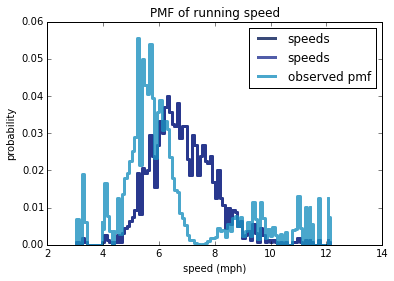

In [5]:
def ObservedPmf(pmf, myspeed):
    new_pmf = pmf.Copy(label='observed pmf')
    average = pmf.Mean()
    print(average)

    for speed, prob in pmf.Items():
        new_pmf.Mult(speed, pow(myspeed - speed, 2))
        
    new_pmf.Normalize()
    return new_pmf


def ex4():
    pmf = relay.pmf()
    observed = ObservedPmf(pmf, 7.5)
    thinkplot.PrePlot(2)
    thinkplot.Pmfs([pmf, observed])
    thinkplot.Show(title='PMF of running speed',
                   xlabel='speed (mph)',
                   ylabel='probability')


ex4()